In [2]:
import xarray as xr

# from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import numpy as np
from netCDF4 import Dataset
# from skimage import transform
from datetime import timedelta
import cartopy.crs as ccrs
import glob
from scipy import stats

In [60]:
month_l = '10'
# dataset= xr.open_dataset(f'E:/ZiYuanPingGu/analyze/SCQA829_2020{month_l}.nc')#读取ERA5 202001整日数据
dataset= xr.open_dataset(f'H:/ZiYuanPingGu/H8data_0908_v/SCQA0908_2020{month_l}.nc')
file_path = glob.glob(f'E:\ZiYuanPingGu\MERRA2_0.5\MERRA2_400.inst1_2d_asm_Nx.2020{month_l}*.SUB.nc')

for num in range(len(file_path)):
    if num == 0:
        ds0 = xr.open_dataset(file_path[num])
        MERRA2_lwparray = ds0.TQL.values
        MERRA2_iwparray = ds0.TQI.values
    else:
        ds = xr.open_dataset(file_path[num])
        lwparray = ds.TQL.values
        iwparray = ds.TQI.values
        MERRA2_lwparray = np.vstack([MERRA2_lwparray, lwparray])
        MERRA2_iwparray = np.vstack([MERRA2_iwparray, iwparray])

#需要做插值，方法线性插值，结果0.5°×0.5°
interp_array = xr.Dataset({
    'TQI':(('time', 'lat', 'lon'), np.zeros([MERRA2_lwparray.shape[0],81,111])),
    'TQL':(('time', 'lat', 'lon'), np.zeros([MERRA2_iwparray.shape[0],81,111])),
    'time':(('time'), np.arange(MERRA2_iwparray.shape[0])),
    'lon':(('lon'),np.linspace(80,135,111)),
    'lat':(('lat'),np.linspace(55,15,81))
})
print(interp_array)

interp_array.TQL.data[:,:,::5] = MERRA2_lwparray[:,:,::4]
interp_array.TQI.data[:,:,::5] = MERRA2_iwparray[:,:,::4]
for i in np.arange(1,5):
    a = [0.8,0.6,0.4,0.2]
    interp_array.TQI.data[:,:,i:-1:5] = MERRA2_iwparray[:,:,i-1:-1:4] + a[i-1]*(MERRA2_iwparray[:,:,i::4]-MERRA2_iwparray[:,:,i-1:-1:4])
    interp_array.TQL.data[:,:,i:-1:5] = MERRA2_lwparray[:,:,i-1:-1:4] + a[i-1]*(MERRA2_lwparray[:,:,i::4]-MERRA2_lwparray[:,:,i-1:-1:4])

MERRA2_lwparray = np.stack(interp_array.TQL.values, axis=2)
MERRA2_iwparray = np.stack(interp_array.TQI.values, axis=2)

MERRA2_CHN_LWP = MERRA2_lwparray[::-1,:,::3]
MERRA2_CHN_IWP = MERRA2_iwparray[::-1,:,::3]

H8_CHN_LWP = np.stack(dataset.MERRA2_data.values[::3,0,:,:], axis=2)
H8_CHN_IWP = np.stack(dataset.MERRA2_data.values[::3,1,:,:], axis=2)

day_delta = MERRA2_CHN_LWP.shape[2]-H8_CHN_LWP.shape[2]
if day_delta != 0:
    print('no equal')
    MERRA2_CHN_LWP = MERRA2_CHN_LWP[:, :, :-day_delta]
    MERRA2_CHN_IWP = MERRA2_CHN_IWP[:, :, :-day_delta]

MERRA2_clc_CHN = xr.open_dataset(fr'E:\ZiYuanPingGu\analyze\Surecloud_{month_l}_MERRA2.nc')#读取MERRA2云检测

#云检测过程处理
# 由于MERRA2的云检测产品时间分辨率为3h, 且lat反向
clc_H8array = np.stack(dataset.MERRA2_data.values[::3,2,:,:], axis=2)
cs_MERRA2array = MERRA2_clc_CHN.MERRA2_sc.values[:,:,:]  #:-8
cs_MERRA2array = np.stack(cs_MERRA2array, axis=2)
print(cs_MERRA2array.shape, clc_H8array.shape)
if cs_MERRA2array.shape[2] == clc_H8array.shape[2]:
    print('equal time')
else:
    min_timeshape =  min(cs_MERRA2array.shape[2], clc_H8array.shape[2])
    cs_MERRA2array = cs_MERRA2array[:,:,:min_timeshape]
    clc_H8array = clc_H8array[:,:,:min_timeshape]
    print('Fixed')
    print(cs_MERRA2array.shape, clc_H8array.shape)
clc_Botharray = clc_H8array * cs_MERRA2array

H8_CHN_LWP[H8_CHN_LWP == -1] = np.nan
H8_CHN_IWP[H8_CHN_IWP == -1] = np.nan

Bias_lwp = MERRA2_CHN_LWP - H8_CHN_LWP
Bias_iwp = MERRA2_CHN_IWP - H8_CHN_IWP
Bias_lwp[clc_Botharray == 0] = np.nan
Bias_iwp[clc_Botharray == 0] = np.nan
Bias_lwp[np.isnan(Bias_lwp)] = -327
Bias_iwp[np.isnan(Bias_iwp)] = -327
H8_CHN_LWP[np.isnan(H8_CHN_LWP)] = -327
H8_CHN_IWP[np.isnan(H8_CHN_IWP)] = -327

valid_Biaslwpdata = np.empty([0])
valid_Biasiwpdata = np.empty([0])
for itime in range(H8_CHN_LWP.shape[2]):
    onetimedata1 = Bias_lwp[:,:,itime]
    onetimedata2 = Bias_iwp[:,:,itime]
    valid_Biaslwpdata = np.hstack([valid_Biaslwpdata,onetimedata1[onetimedata1 != -327]])
    valid_Biasiwpdata = np.hstack([valid_Biasiwpdata,onetimedata2[onetimedata2 != -327]])

STD_LWP = np.std(valid_Biaslwpdata)
MEAN_LWP = np.mean(valid_Biaslwpdata)
RMSE_LWP = np.sqrt(sum(valid_Biaslwpdata**2)/len(valid_Biaslwpdata))

STD_IWP = np.std(valid_Biasiwpdata)
MEAN_IWP = np.mean(valid_Biasiwpdata)
RMSE_IWP = np.sqrt(sum(valid_Biasiwpdata**2)/len(valid_Biasiwpdata))
print(MEAN_LWP, STD_LWP, RMSE_LWP)
print(MEAN_IWP, STD_IWP, RMSE_IWP)


def Get_origin_stack(dataset1, dataset2, looptime):
    D1 = dataset1.shape[0]
    D2 = dataset1.shape[1]
    data_stack1 = np.zeros([D1, D2, looptime])
    data_stack2 = np.zeros([D1, D2, looptime])
    Countvalid_stack = np.zeros([D1, D2])
    for itime in range(looptime):
        onetimedata1 = dataset1[:,:,itime]
        onetimedata2 = dataset2[:,:,itime]
        Countvalid_stack[onetimedata1 != -327] += 1
        data_stack1[:,:,itime][onetimedata1 != -327] = onetimedata1[onetimedata1 != -327]
        data_stack2[:,:,itime][onetimedata1 != -327] = onetimedata2[onetimedata1 != -327]
        
    Mean_sum1 = data_stack1.sum(axis=2)/looptime
    Mean_sum2 = data_stack2.sum(axis=2)/looptime
    Mean_sum3 = dataset2.sum(axis=2)/looptime
    
    return Mean_sum1, Mean_sum2, Mean_sum3, Countvalid_stack
H8array_lwp, MERRA2array_lwp, addMERRA2_lwp, Countvalid_stack_lwp = Get_origin_stack(H8_CHN_LWP, MERRA2_CHN_LWP, H8_CHN_LWP.shape[2])
H8array_iwp, MERRA2array_iwp, addMERRA2_iwp, Countvalid_stack_iwp = Get_origin_stack(H8_CHN_IWP, MERRA2_CHN_IWP, H8_CHN_LWP.shape[2])

x = np.linspace(80.0, 135.0, 111)
y = np.linspace(55.0, 15.0, 81)
X, Y = np.meshgrid(x, y)
array_Biaslwp = MERRA2array_lwp - H8array_lwp
array_Biasiwp = MERRA2array_iwp - H8array_iwp

<xarray.Dataset>
Dimensions:  (time: 744, lat: 81, lon: 111)
Coordinates:
  * time     (time) int32 0 1 2 3 4 5 6 7 8 ... 736 737 738 739 740 741 742 743
  * lon      (lon) float64 80.0 80.5 81.0 81.5 82.0 ... 133.5 134.0 134.5 135.0
  * lat      (lat) float64 55.0 54.5 54.0 53.5 53.0 ... 17.0 16.5 16.0 15.5 15.0
Data variables:
    TQI      (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    TQL      (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
no equal
(81, 111, 248) (81, 111, 240)
Fixed
(81, 111, 240) (81, 111, 240)
-0.05039332783080042 0.11461818554231505 0.1252070922387185
-0.7333343060933988 1.1644958575218416 1.376164890803069


In [45]:
x.shape, y.shape

((111,), (81,))

In [51]:
ds.close()

In [61]:
import os

storefile_path = r'H:/ZiYuanPingGu/result2022'
read_path = storefile_path+f'/resm2_{month_l}.nc'
if os.path.exists(read_path):
    ds = xr.open_dataset(read_path)
    # ds["lat_m2"] = y
    # ds["lon_m2"] = x
    ds['MERRA2_lwp_mm'] = (("lat_m2", "lon_m2"), MERRA2array_lwp)
    ds['MERRA2_iwp_mm'] = (("lat_m2", "lon_m2"), MERRA2array_iwp)
    # ds['H8_lwp_mm'] = ERA5array_lwp
    # ds['H8_iwp_mm'] = ERA5array_iwp
    ds['MERRA2_biaslwp_mm'] = (("lat_m2", "lon_m2"), array_Biaslwp)
    ds['MERRA2_biasiwp_mm'] = (("lat_m2", "lon_m2"), array_Biasiwp)
    ds.close()
    ds.to_netcdf(read_path)
else:
    ds = xr.Dataset({'MERRA2_lwp_mm':(('lat_m2', 'lon_m2'), MERRA2array_lwp),
                    'MERRA2_iwp_mm':(('lat_m2', 'lon_m2'), MERRA2array_iwp),
                    'MERRA2_biaslwp_mm':(('lat_m2', 'lon_m2'), array_Biaslwp),
                    'MERRA2_biasiwp_mm':(('lat_m2', 'lon_m2'),array_Biasiwp)},
                    # coords={
                    #     'lat':(y),
                    #     'lon':(x)
                    # }
    )
    ds.close()
    ds.to_netcdf(read_path)

In [4]:
from plot_bias_funtions import Plot_ComparedPic

value_max:0.004673816648531715, value_min:-0.12281049677573154
level_limit : 0.1
level_limit : 0.1
level: 2


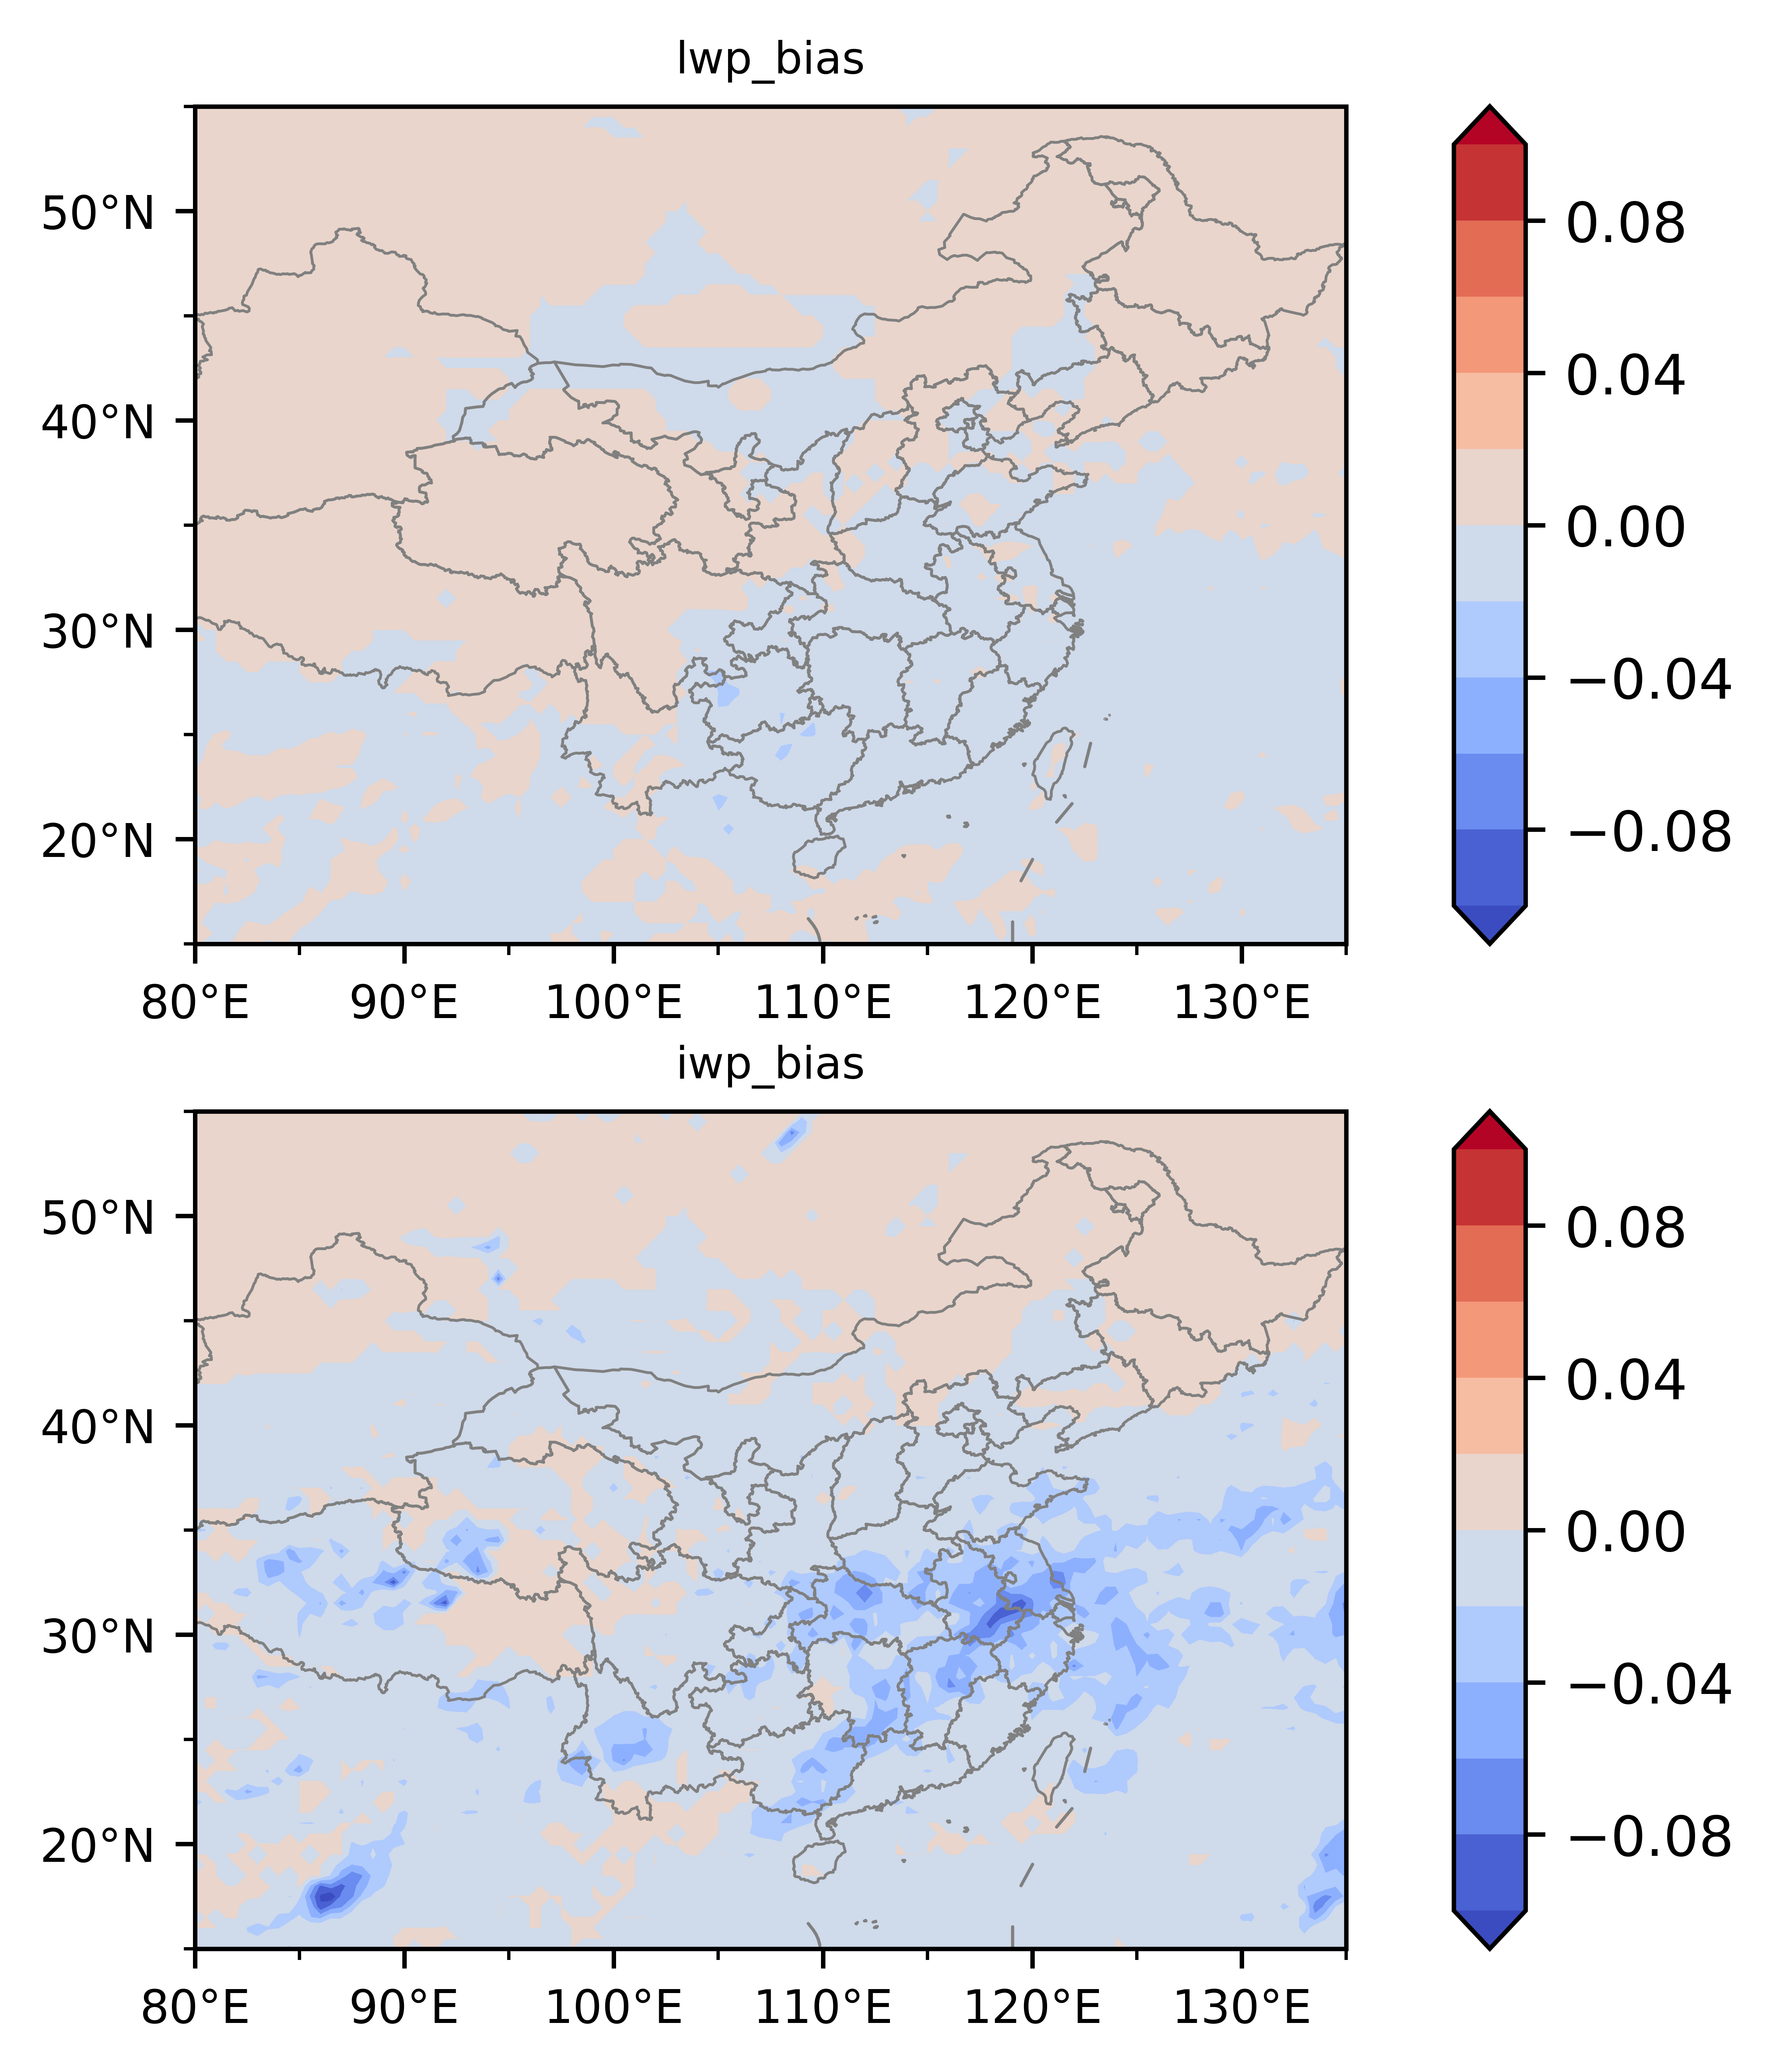

In [5]:
Plot_ComparedPic(x, y, array_Biaslwp, array_Biasiwp, 'bias_lwp_01', 'lwp_bias', 'iwp_bias', 'coolwarm', directionLevels=False)

value_max:0.044807776780434475, value_min:0.0
level_limit : 0.0
level_limit : 0.04
level: 2


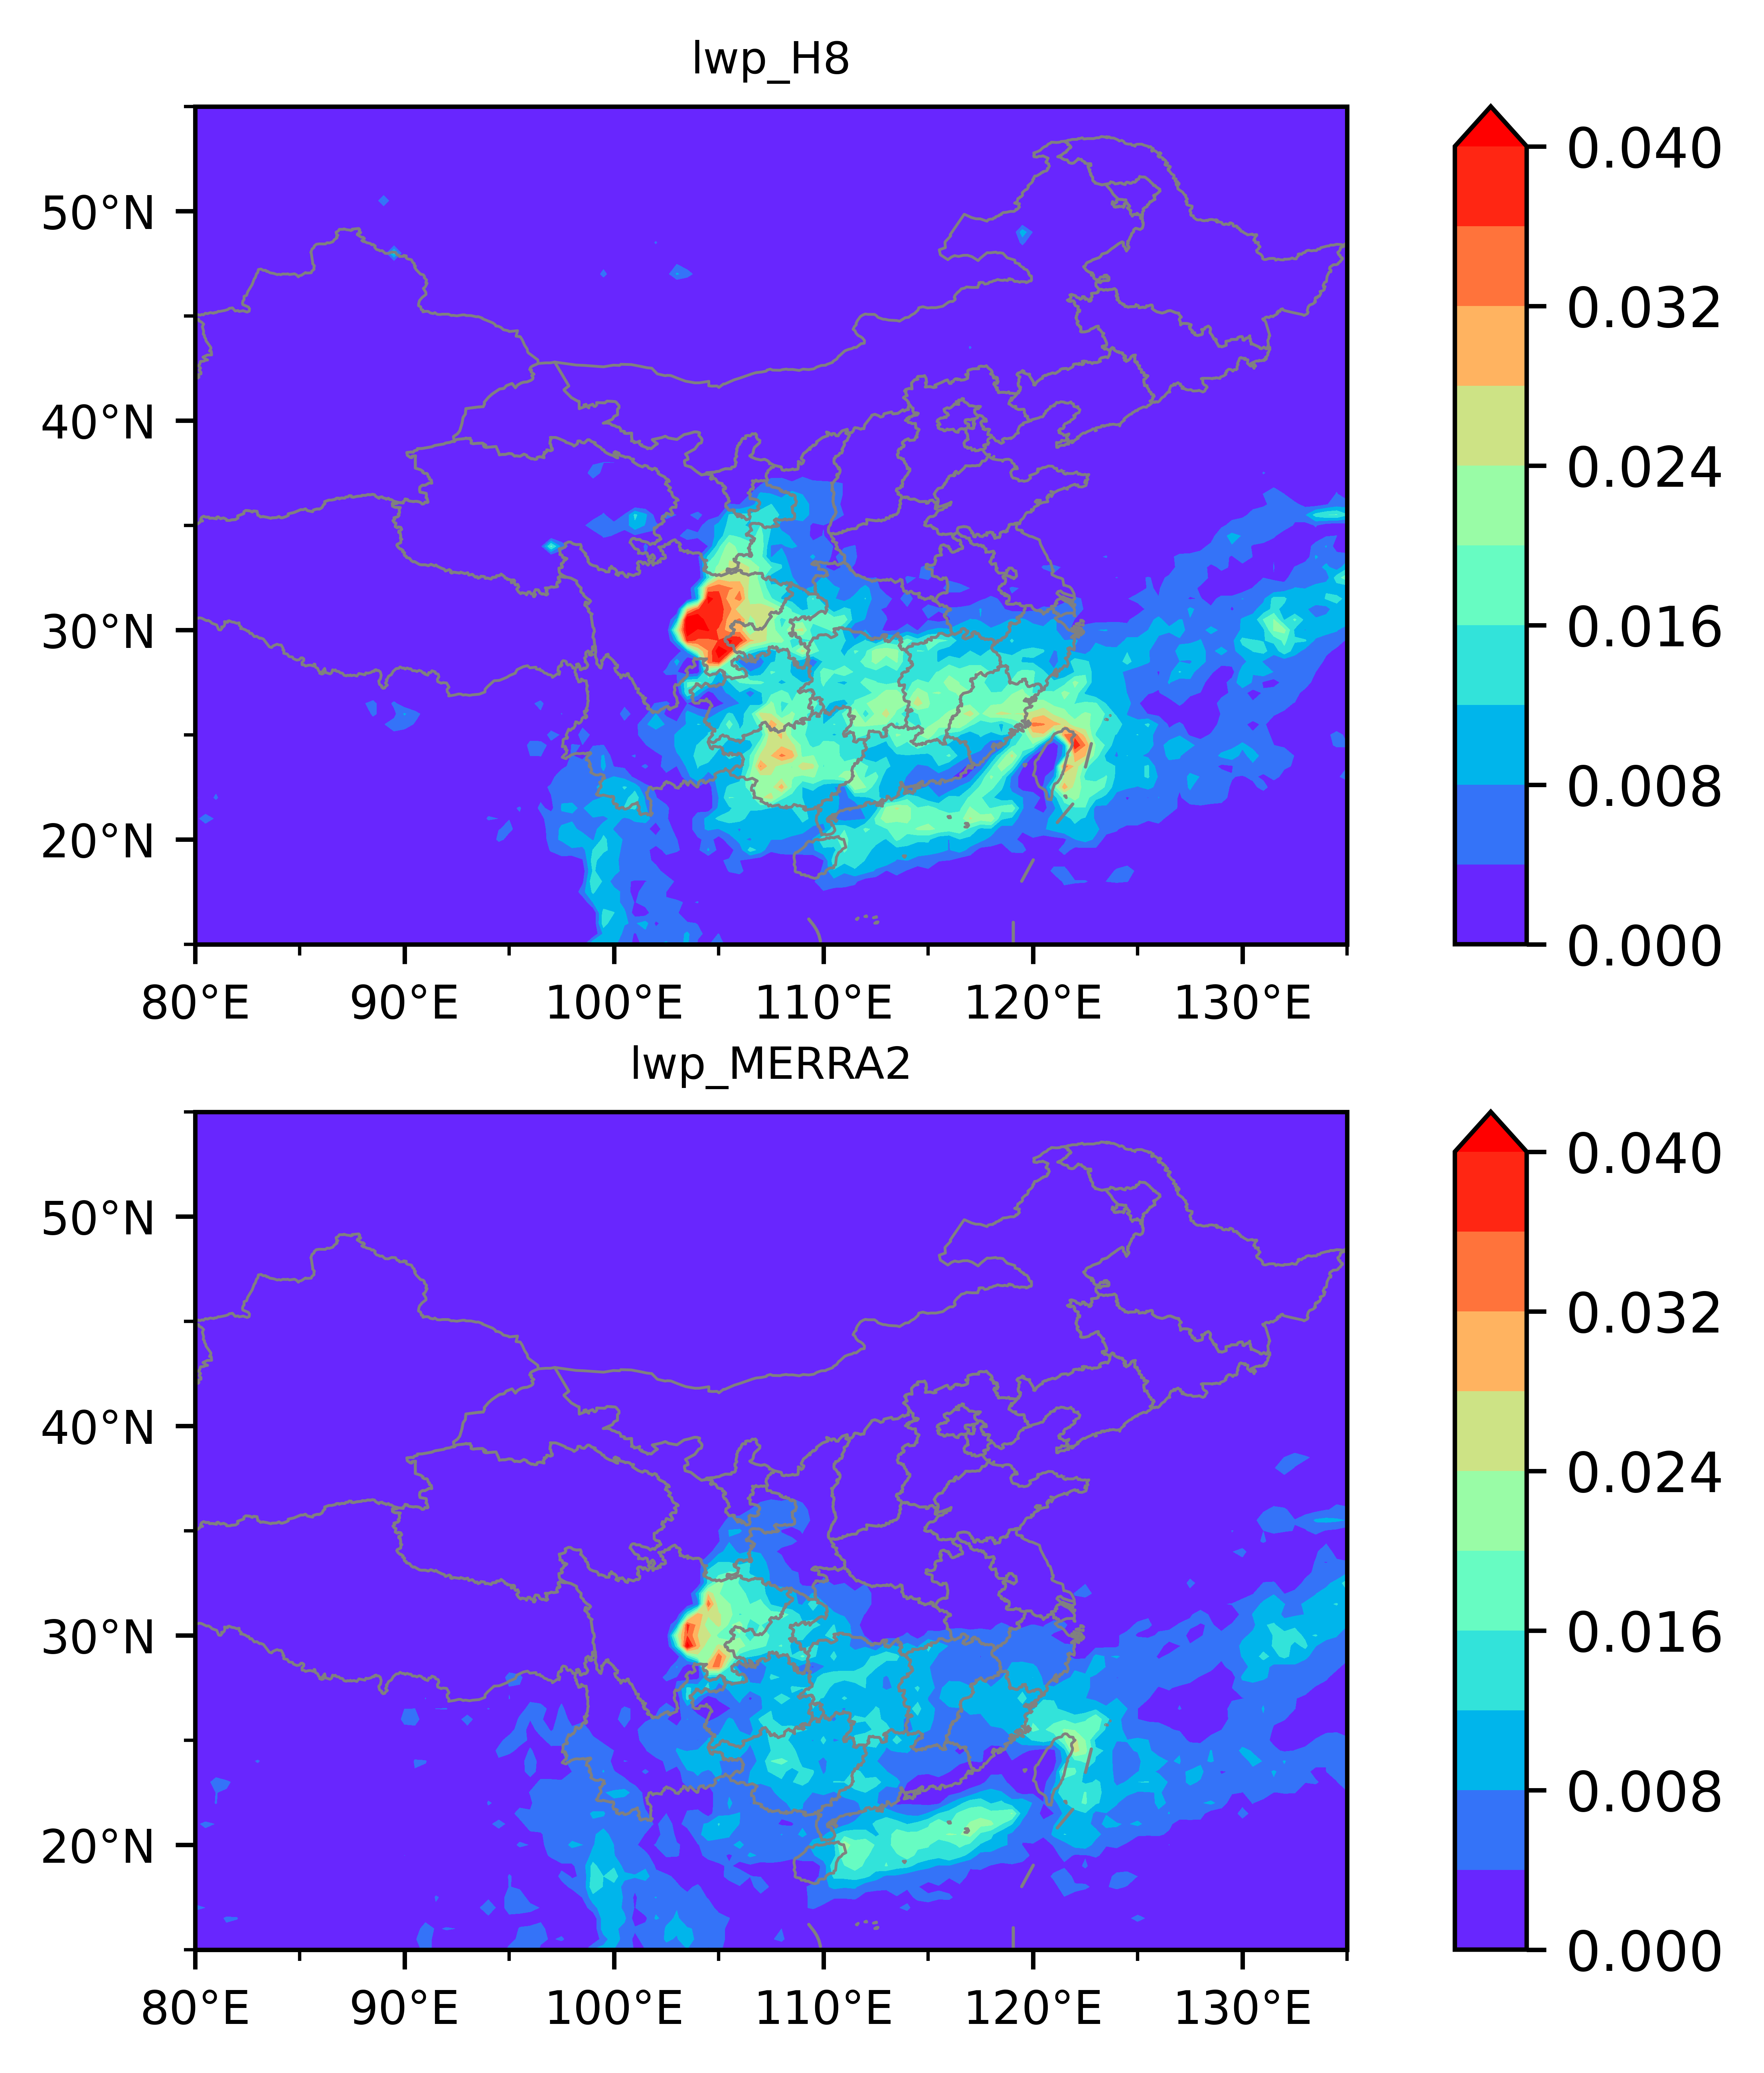

In [21]:
Plot_ComparedPic(x, y, H8array_lwp, MERRA2array_lwp, 'origin_lwp_10', 'lwp_H8', 'lwp_MERRA2', 'rainbow')

value_max:0.7043934146146799, value_min:0.0
level_limit : 0.6
level: 1


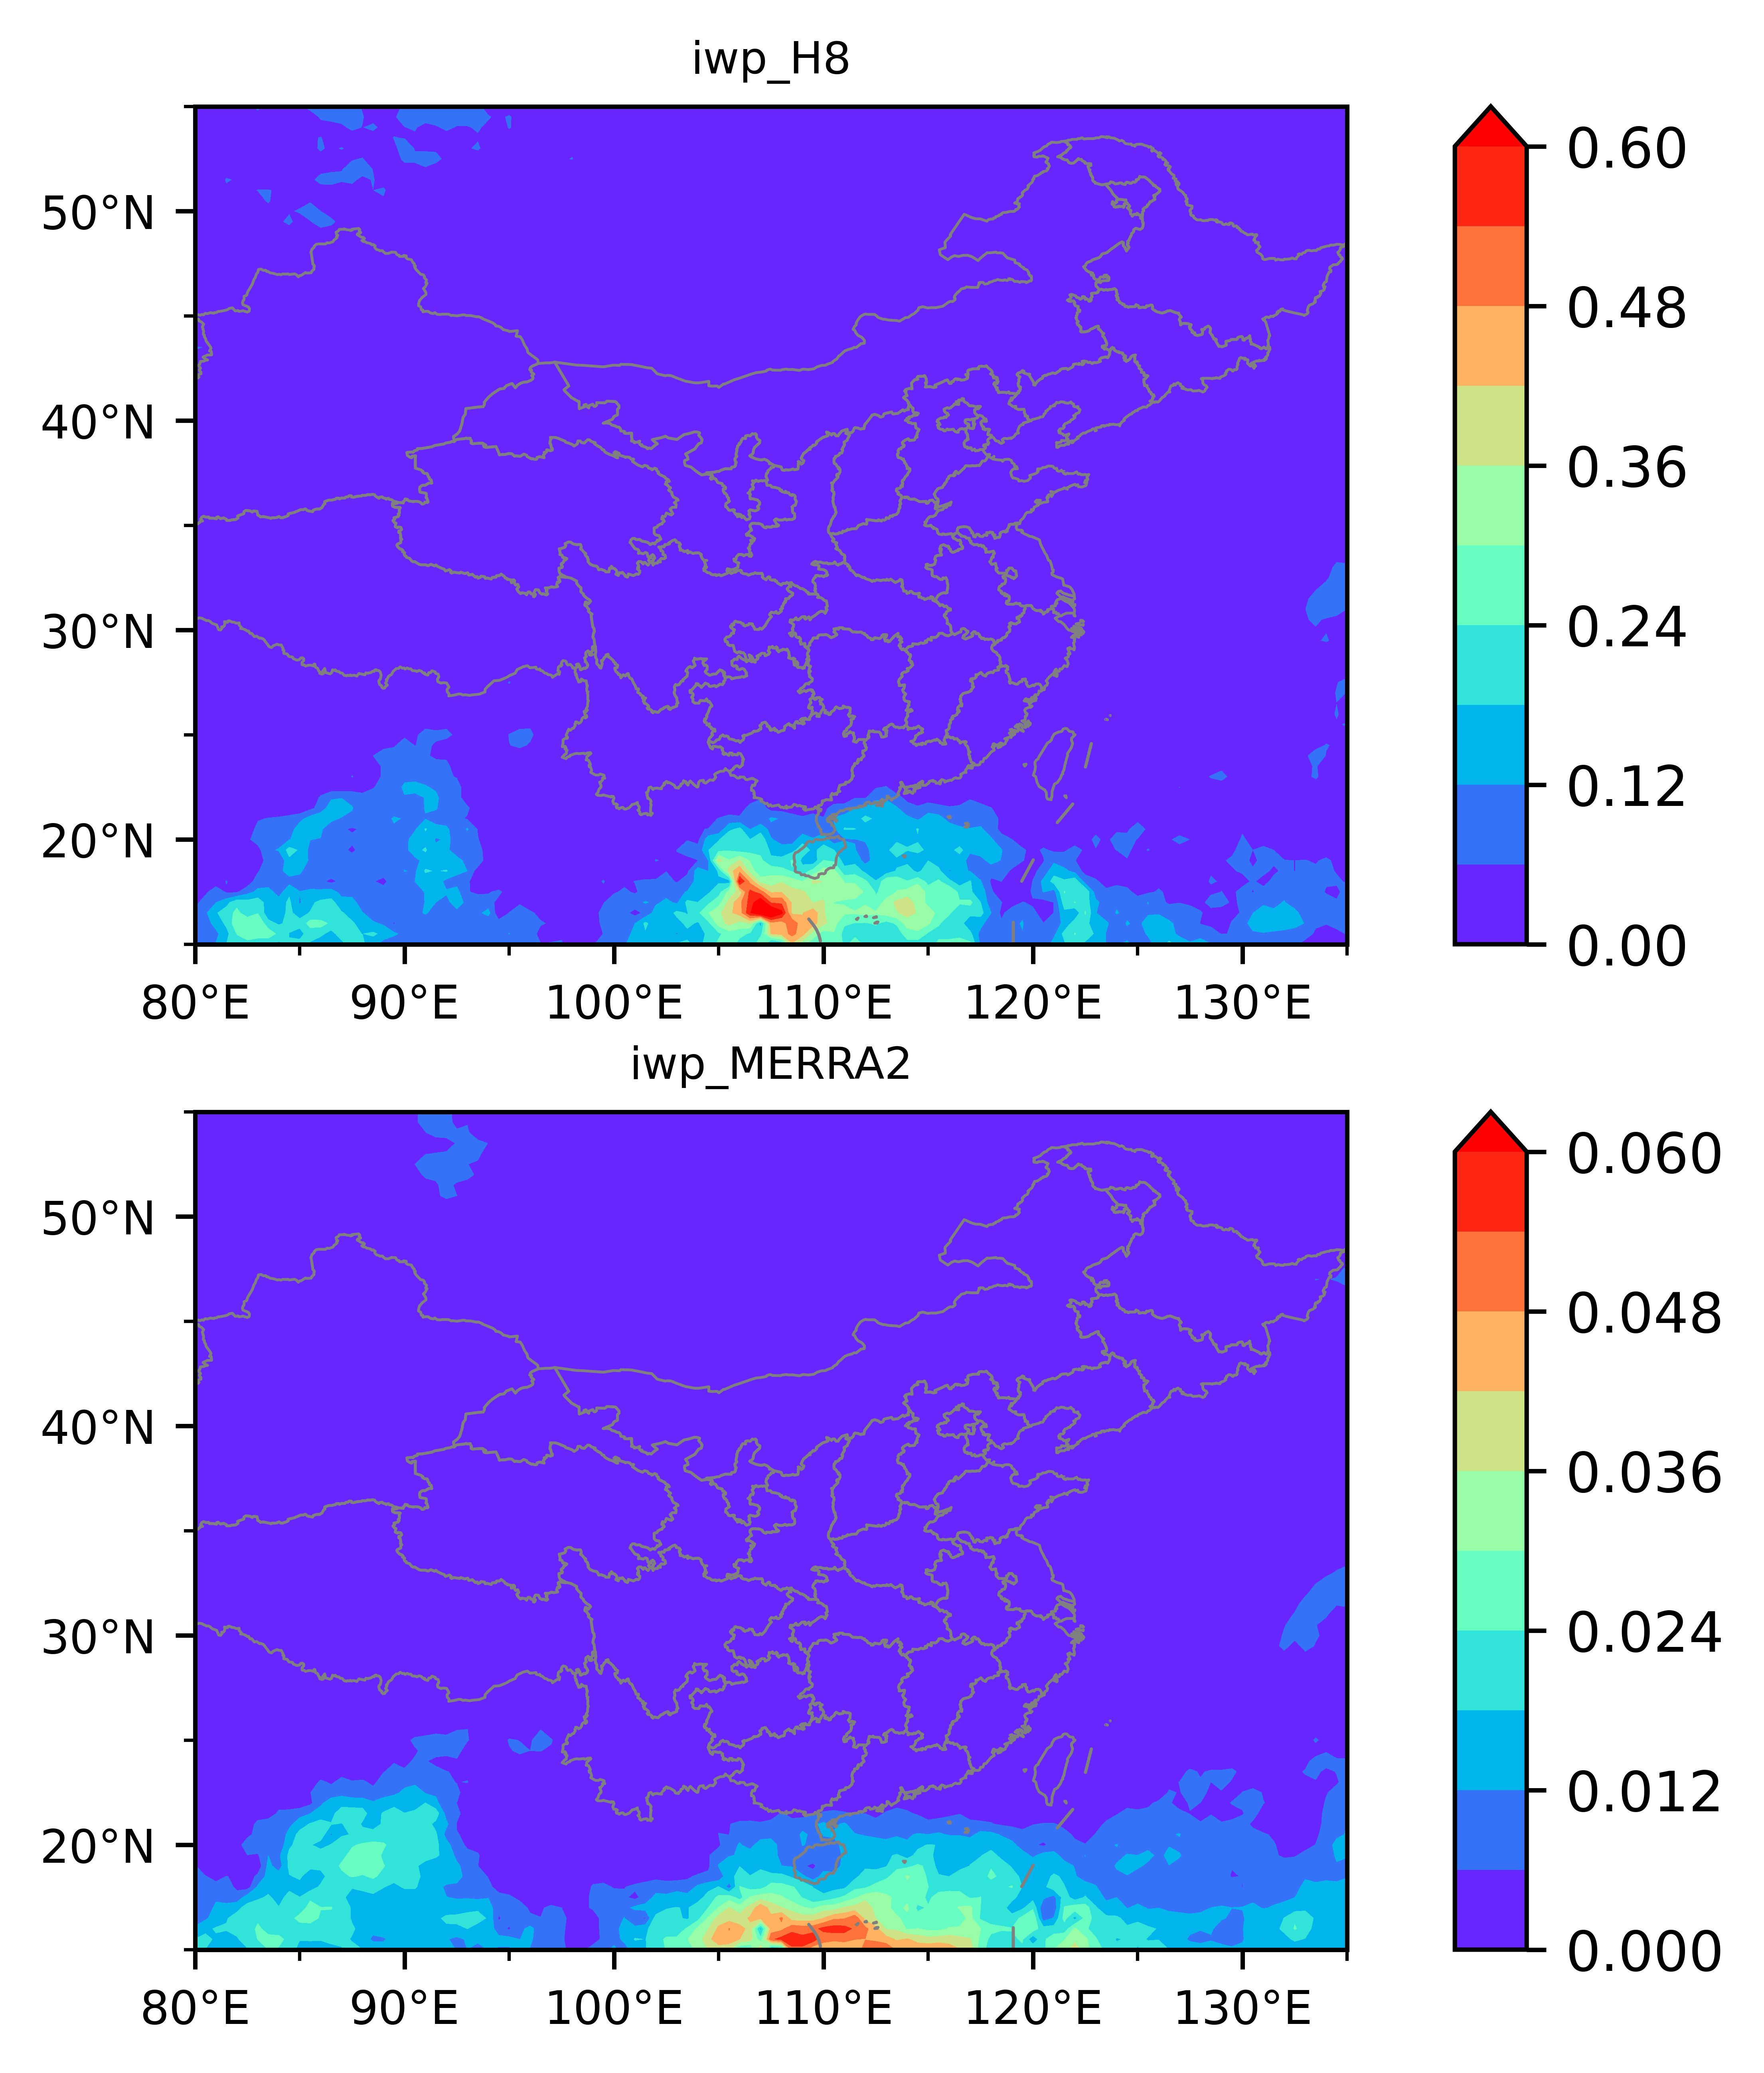

In [22]:
Plot_ComparedPic(x, y, H8array_iwp, MERRA2array_iwp, 'origin_iwp_10', 'iwp_H8', 'iwp_MERRA2', 'rainbow', decascale=True)

In [4]:
ds1 = xr.open_dataset(file_path[0])
ds1

<xarray.Dataset>
Dimensions:  (time: 24, lon: 89, lat: 81)
Coordinates:
  * time     (time) datetime64[ns] 2020-04-01 ... 2020-04-01T23:00:00
  * lon      (lon) float64 80.0 80.62 81.25 81.88 ... 133.1 133.8 134.4 135.0
  * lat      (lat) float64 15.0 15.5 16.0 16.5 17.0 ... 53.0 53.5 54.0 54.5 55.0
Data variables:
    TQI      (time, lat, lon) float32 ...
    TQL      (time, lat, lon) float32 ...
Attributes: (12/32)
    CDI:                               Climate Data Interface version 1.9.8 (...
    Conventions:                       CF-1
    History:                           Original file generated: Sat Apr 11 21...
    Comment:                           GMAO filename: d5124_m2_jan10.inst1_2d...
    Filename:                          MERRA2_400.inst1_2d_asm_Nx.20200401.nc4
    Institution:                       NASA Global Modeling and Assimilation ...
    ...                                ...
    RangeBeginningDate:                2020-04-01
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   2020-04-01
    RangeEndingTime:                   23:00:00.000000
    history_L34RS:                     'Created by L34RS v1.4.2 @ NASA GES DI...
    CDO:                               Climate Data Operators version 1.9.8 (...

In [5]:
# np.stack(ds1.cwat.values, axis=2).shape

In [6]:
# D1 = len(file_path)*4
# D2 = ds1.cwat.shape[1]
# D3 = ds1.cwat.shape[2]


In [12]:
MERRA2_iwparray.shape

(81, 111, 720)

In [13]:
MERRA2_lwparray.shape

(81, 111, 720)

### 由于MERRA2的云检测产品时间分辨率为3h, 且lat反向

(81, 111, 240)

In [17]:
CFSR_CHN_LWP.shape

(81, 111, 240)

<xarray.Dataset>
Dimensions:    (time: 240, lat: 81, lon: 111)
Coordinates:
  * time       (time) datetime64[ns] 2020-04-01 ... 2020-04-30T21:00:00
Dimensions without coordinates: lat, lon
Data variables:
    MERRA2_sc  (time, lat, lon) float64 ...

(240, 81, 111) (81, 111, 240)


C:\Users\dell\AppData\Local\Temp\ipykernel_11092\3308066204.py:14: RuntimeWarning: invalid value encountered in true_divide
  Mean_sum1 = data_stack1.sum(axis=2)/Countvalid_stack
C:\Users\dell\AppData\Local\Temp\ipykernel_11092\3308066204.py:15: RuntimeWarning: invalid value encountered in true_divide
  Mean_sum2 = data_stack2.sum(axis=2)/Countvalid_stack


In [27]:
Biaslwp_f = array_Biaslwp.flatten()
Biaslwp_n = Biaslwp_f[~np.isnan(Biaslwp_f)]
Biaslwp_n

array([ 0.00108714, -0.00488756, -0.0190389 , ..., -0.05490698,
       -0.0093213 ,  0.07980494])

In [28]:
np.mean(Biaslwp_n), np.sqrt(np.sum(Biaslwp_n**2)/len(Biaslwp_n)), np.std(Biaslwp_n)

(-0.011192263080782017, 0.06045795164614697, 0.05941293768514068)

In [29]:
def Plot_2_pic(data1, data2, picname, title1, title2, colorp):
    extent = [80, 135, 15, 55]#100E--110E,25N--35N
    proj = ccrs.PlateCarree()#选择投影方式，平面投影
    fig = plt.figure(figsize=(9,6), dpi=1000)
    ax1 = fig.add_subplot(211, projection=proj)#创建一个轴，或者是说主体
    # 设置经纬度刻度.
    set_map_ticks(ax1, dx=10, dy=10, nx=1, ny=1, labelsize='small')#自定义函数set_map_tick
    ax1.set_extent(extent, crs=proj)
    ax1.set_title(title1, fontsize=8)
    # im = plt.pcolormesh(lon_mesh, lat_mesh, dem_data,cmap = "rainbow")
#     levels = [-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
    levels = np.linspace(-0.5, 0.5, 11)
    im1 = ax1.contourf(X, Y, data1, cmap = colorp, levels = levels, extend='both')
    add_Chinese_provinces(ax1, lw=0.5, ec='gray', fc='none')#后两个参数是设置eagecolor,facecolor,linewigth线宽
    #设置colorbar的位置
    cax1 = fig.add_axes([ax1.get_position().x1 + 0.03, ax1.get_position().y0, 0.02, ax1.get_position().height])
    plt.colorbar(im1, cax=cax1)

    ax2 = fig.add_subplot(212, projection=proj)#创建一个轴，或者是说主体
    # 设置经纬度刻度.
    set_map_ticks(ax2, dx=10, dy=10, nx=1, ny=1, labelsize='small')#自定义函数set_map_tick
    ax2.set_extent(extent, crs=proj)
    ax2.set_title(title2, fontsize=8)
    # im = plt.pcolormesh(lon_mesh, lat_mesh, dem_data,cmap = "rainbow")
#     levels = np.linspace(-1.5, 1.5, 11)
#     levels = np.linspace(0, 0.1, 11)
    im2 = ax2.contourf(X, Y, data2, cmap = colorp, levels = levels, extend='both')
    add_Chinese_provinces(ax2, lw=0.5, ec='gray', fc='none')#后两个参数是设置eagecolor,facecolor,linewigth线宽
    #设置colorbar的位置
    cax2 = fig.add_axes([ax2.get_position().x1 + 0.03, ax2.get_position().y0, 0.02, ax2.get_position().height])
    plt.colorbar(im2, cax=cax2)
#     plt.savefig(f'D:/python project/python_qixianglianxi/ZiYuanPingGu/analyze_draw/{picname}.png',
#                 dpi=100,
#                 bbox_inches = 'tight'
#     #             facecolor = 'g',
#     #             edgecolor = 'b'
#                )
    plt.show()

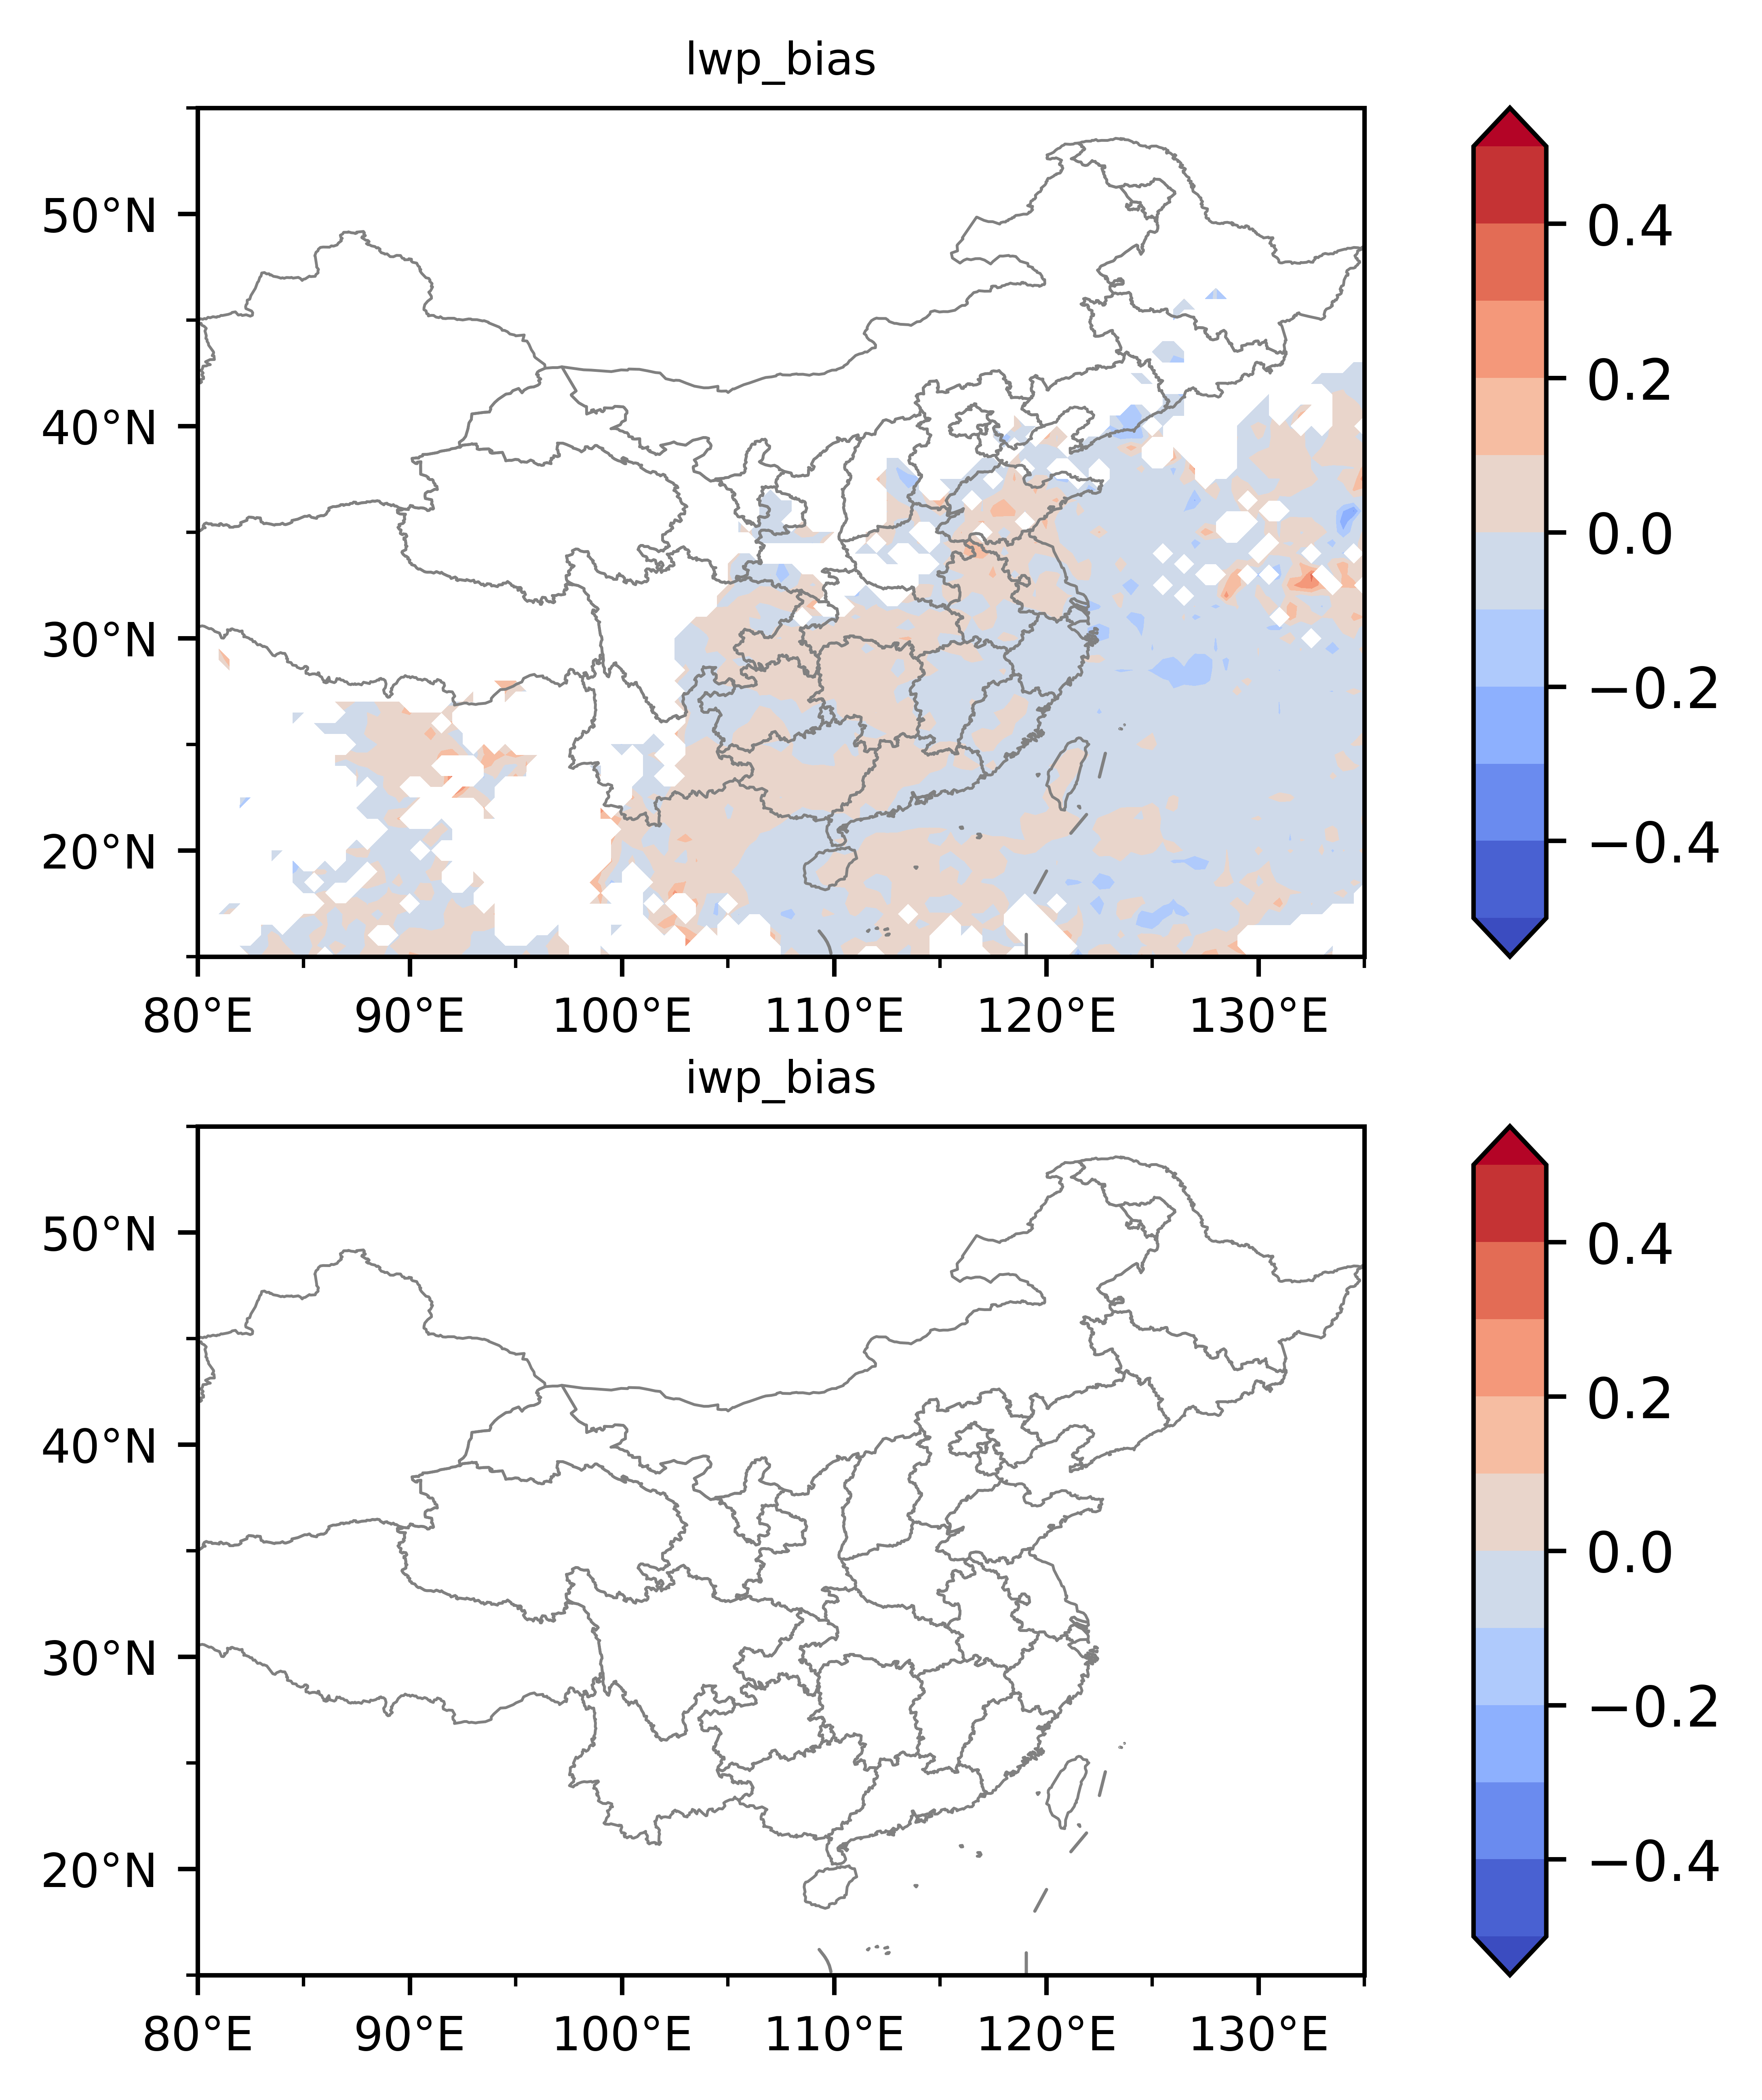

In [30]:
Plot_2_pic(array_Biaslwp, array_Biasiwp, 'bias_lwp_01', 'lwp_bias', 'iwp_bias', 'coolwarm')

In [31]:
def Plot_22_pic(data1, data2, picname, title1, title2, colorp):
    extent = [80, 135, 15, 55]#100E--110E,25N--35N
    proj = ccrs.PlateCarree()#选择投影方式，平面投影
    fig = plt.figure(figsize=(9,6), dpi=1000)
    ax1 = fig.add_subplot(211, projection=proj)#创建一个轴，或者是说主体
    # 设置经纬度刻度.
    set_map_ticks(ax1, dx=10, dy=10, nx=1, ny=1, labelsize='small')#自定义函数set_map_tick
    ax1.set_extent(extent, crs=proj)
    ax1.set_title(title1, fontsize=8)
    # im = plt.pcolormesh(lon_mesh, lat_mesh, dem_data,cmap = "rainbow")
#     levels = [-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
    levels = np.linspace(0, 0.6, 11)
    im1 = ax1.contourf(X, Y, data1, cmap = colorp, levels = levels, extend='max')
    add_Chinese_provinces(ax1, lw=0.5, ec='gray', fc='none')#后两个参数是设置eagecolor,facecolor,linewigth线宽
    #设置colorbar的位置
    cax1 = fig.add_axes([ax1.get_position().x1 + 0.03, ax1.get_position().y0, 0.02, ax1.get_position().height])
    plt.colorbar(im1, cax=cax1)

    ax2 = fig.add_subplot(212, projection=proj)#创建一个轴，或者是说主体
    # 设置经纬度刻度.
    set_map_ticks(ax2, dx=10, dy=10, nx=1, ny=1, labelsize='small')#自定义函数set_map_tick
    ax2.set_extent(extent, crs=proj)
    ax2.set_title(title2, fontsize=8)
    # im = plt.pcolormesh(lon_mesh, lat_mesh, dem_data,cmap = "rainbow")
    levels = np.linspace(0, 0.6, 11)
#     levels = np.linspace(0, 0.1, 11)
    im2 = ax2.contourf(X, Y, data2, cmap = colorp, levels = levels, extend='max')
    add_Chinese_provinces(ax2, lw=0.5, ec='gray', fc='none')#后两个参数是设置eagecolor,facecolor,linewigth线宽
    #设置colorbar的位置
    cax2 = fig.add_axes([ax2.get_position().x1 + 0.03, ax2.get_position().y0, 0.02, ax2.get_position().height])
    plt.colorbar(im2, cax=cax2)
#     plt.savefig(f'D:/python project/python_qixianglianxi/ZiYuanPingGu/analyze_draw/{picname}.png',
#                 dpi=100,
#                 bbox_inches = 'tight'
#     #             facecolor = 'g',
#     #             edgecolor = 'b'
#                )
    plt.show()

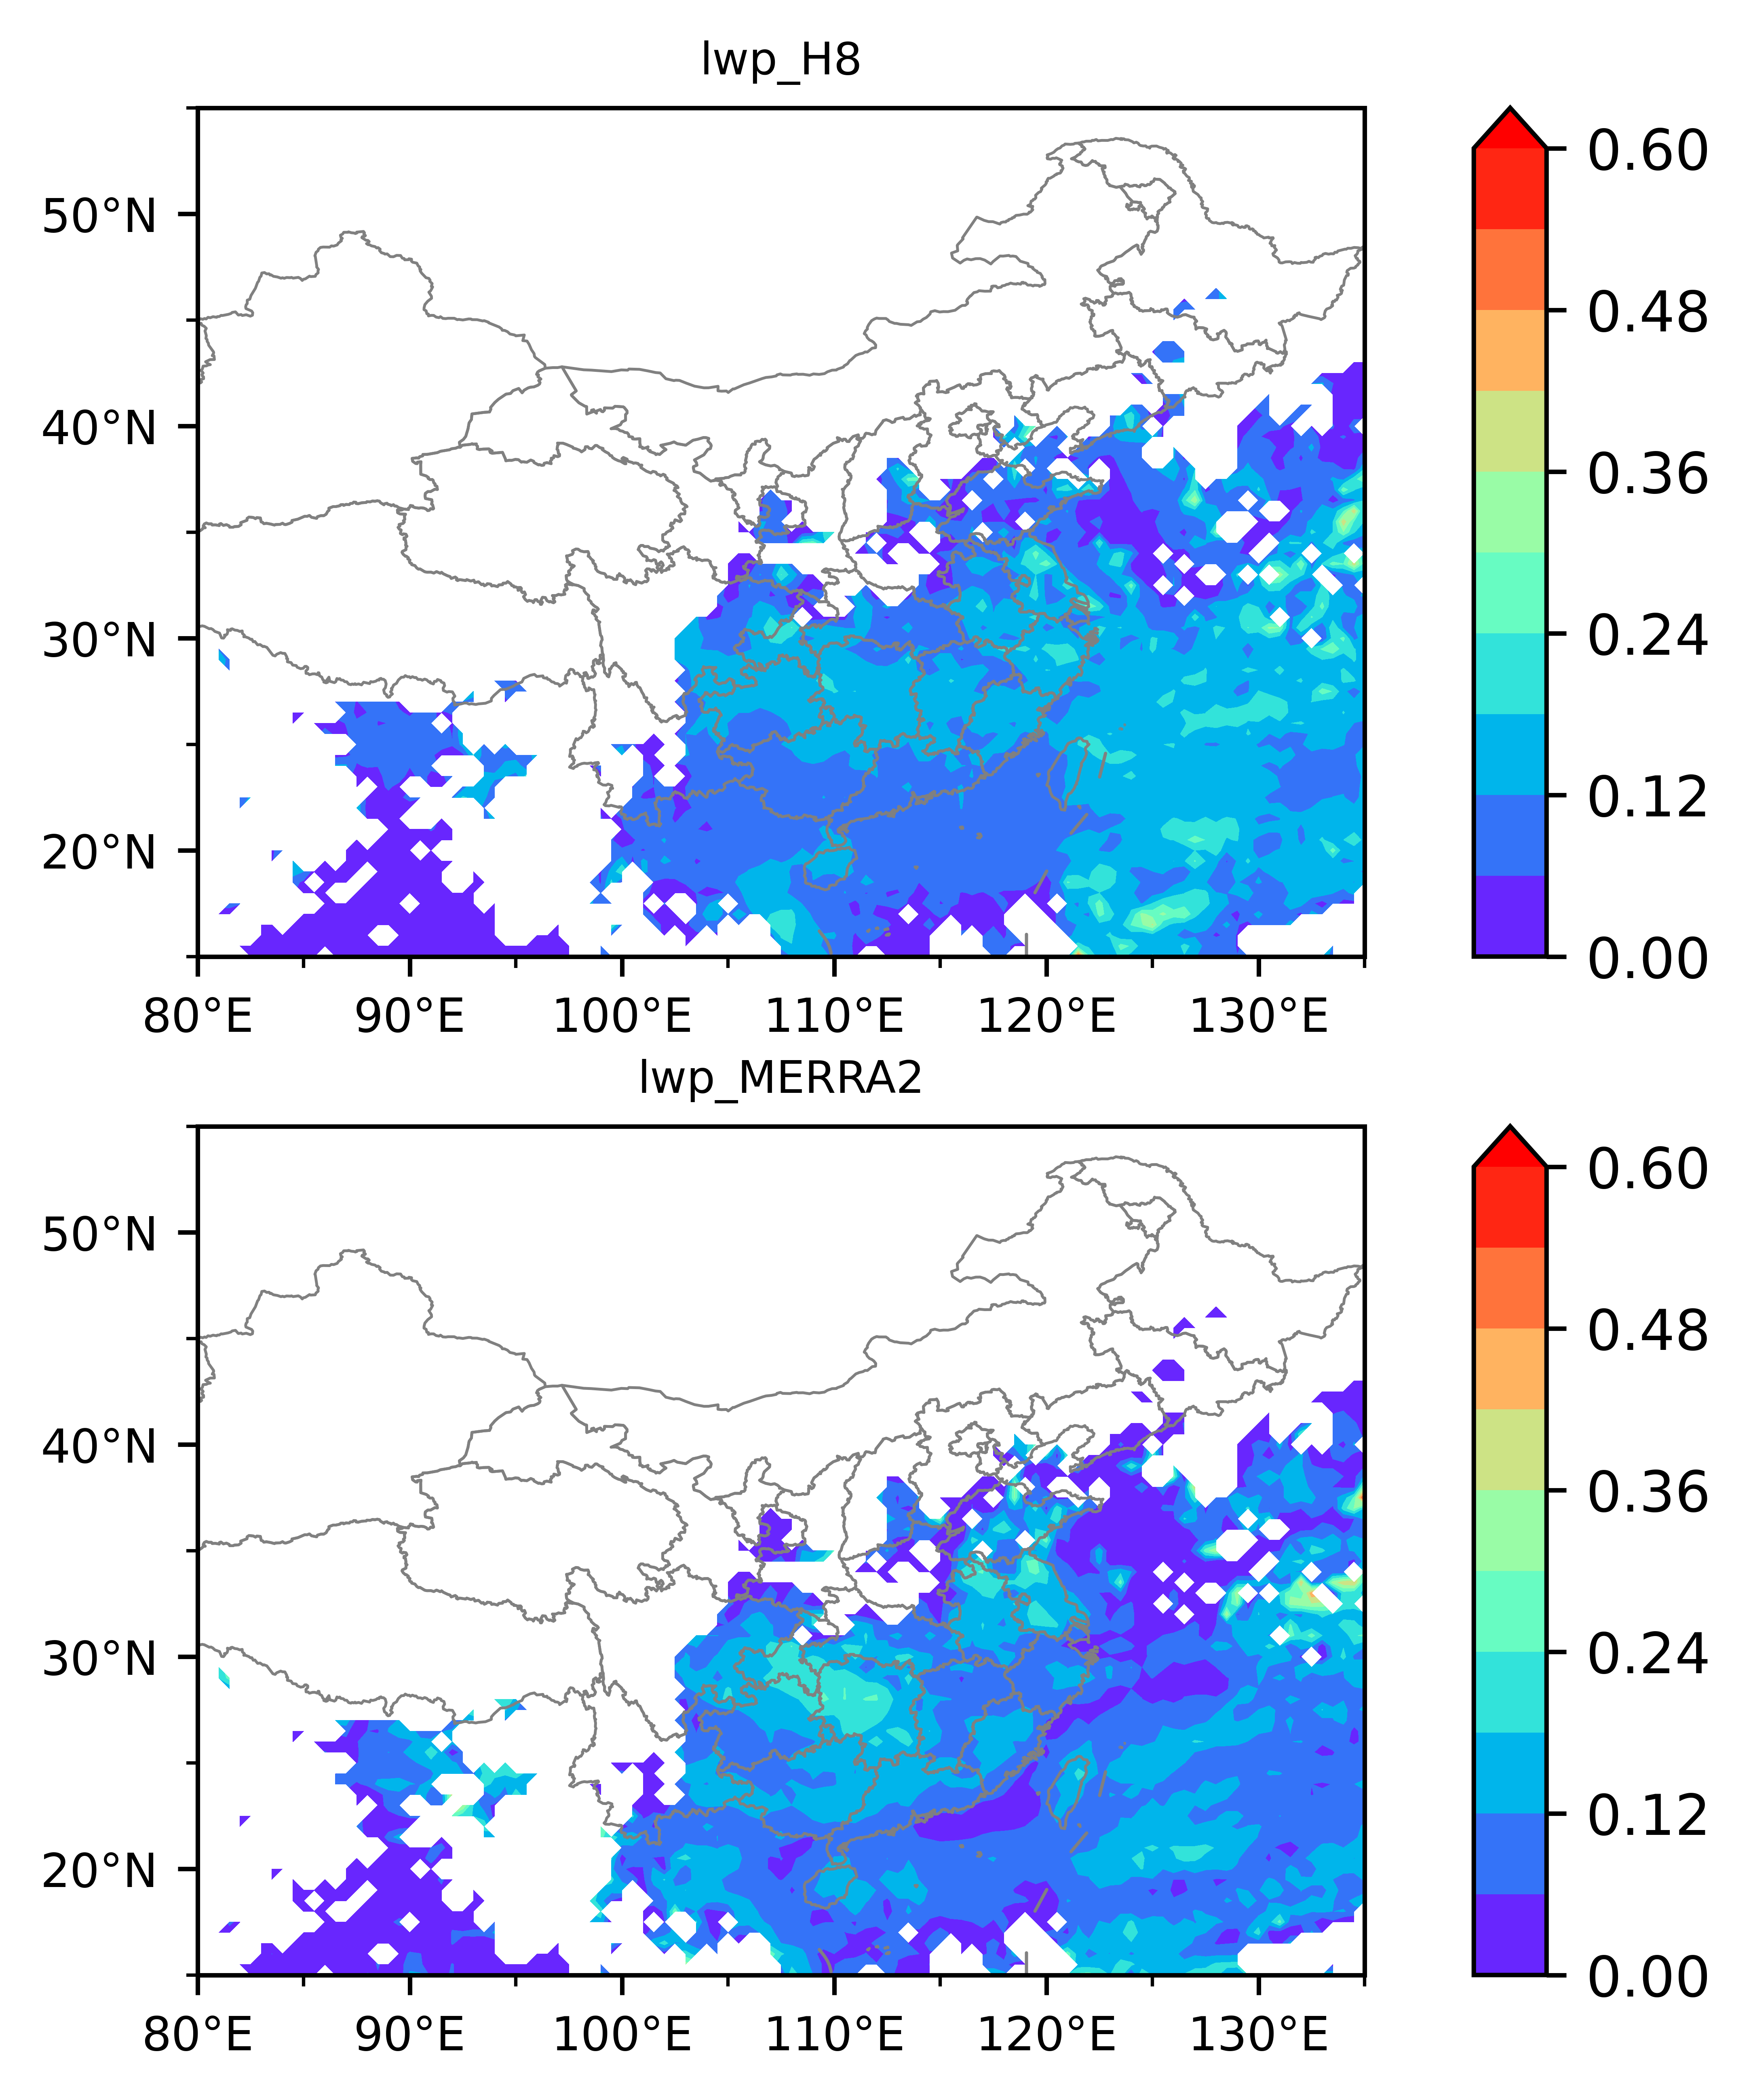

In [32]:
Plot_22_pic(H8array_lwp, ERA5array_lwp, 'origin_lwp_10', 'lwp_H8', 'lwp_MERRA2', 'rainbow')

In [34]:
# Plot_22_pic(H8array_iwp, ERA5array_iwp, 'origin_lwp_10', 'iwp_H8', 'iwp_MERRA2', 'rainbow')

In [38]:
# ds = xr.open_dataset(r'E:\ZiYuanPingGu\result2\10.nc')
# ds
# ds['bias_MERRA2lwp'] = (('lat2', 'lon2'), array_Biaslwp)
# ds['bias_MERRA2iwp'] = (('lat2', 'lon2'), array_Biasiwp)
# ds['MERRA2_lwp_mm'] = (('lat2', 'lon2'), ERA5array_lwp)
# ds['MERRA2_iwp_mm'] = (('lat2', 'lon2'), ERA5array_iwp)
# ds['MERRA2_ym1'] = y_mean1
# ds['MERRA2_ym2'] = y_mean2
# ds['MERRA2_eb1'] = y_error1
# ds['MERRA2_eb2'] = y_error2
# ds.close()
# ds.to_netcdf('E:/ZiYuanPingGu/result2/10.nc')